In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mobile-price-classification/train.csv
/kaggle/input/mobile-price-classification/test.csv


# 1-) Leitura dos Dados

In [2]:
train_df = pd.read_csv('../input/mobile-price-classification/train.csv')
test_df = pd.read_csv('../input/mobile-price-classification/test.csv')

print(train_df.shape)
print(test_df.shape)
train_df.head()

(2000, 21)
(1000, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


1.1-) Preprocessing

In [3]:
# Existem alguns problemas na base, sc_w=0 não faz sentido, e na EDA foi possivel perceber que existem valores zeros.

train_df = train_df[(train_df['sc_w']!=0) & (train_df['px_height']!=0)]

# 2-) Feature Engineering

In [4]:
def bck_cores(nc):
    if(nc<2.5):
        return 'g1_c'
    elif(nc>2.5 and nc<3.5):
        return 'g2_c'
    elif(nc>3.5 and nc<5.5):
        return 'g3_c'
    elif(nc>5.5 and nc<6.5):
        return 'g4_c'
    else:
        return 'g5_c'

train_df['n_cores_bck'] = train_df['n_cores'].apply(lambda nc: bck_cores(nc))
train_df = pd.get_dummies(train_df,columns=['n_cores_bck'],drop_first=True)
train_df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,sc_w,talk_time,three_g,touch_screen,wifi,price_range,n_cores_bck_g2_c,n_cores_bck_g3_c,n_cores_bck_g4_c,n_cores_bck_g5_c
0,842,0,2.2,0,1,0,7,0.6,188,2,...,7,19,0,0,1,1,0,0,0,0
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,3,7,1,1,0,2,1,0,0,0
2,563,1,0.5,1,2,1,41,0.9,145,5,...,2,9,1,1,0,2,0,1,0,0
3,615,1,2.5,0,0,0,10,0.8,131,6,...,8,11,1,0,0,2,0,0,1,0
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,2,15,1,1,0,1,0,0,0,0


In [5]:
def bck_mdep(nc):
    if(nc<0.45):
        return 'g1_dep'
    elif(nc>0.45 and nc<0.65):
        return 'g2_dep'
    else:
        return 'g3_dep'

train_df['m_dep_bck'] = train_df['m_dep'].apply(lambda nc: bck_mdep(nc))
train_df = pd.get_dummies(train_df,columns=['m_dep_bck'],drop_first=True)
train_df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,three_g,touch_screen,wifi,price_range,n_cores_bck_g2_c,n_cores_bck_g3_c,n_cores_bck_g4_c,n_cores_bck_g5_c,m_dep_bck_g2_dep,m_dep_bck_g3_dep
0,842,0,2.2,0,1,0,7,0.6,188,2,...,0,0,1,1,0,0,0,0,1,0
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,1,1,0,2,1,0,0,0,0,1
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1,1,0,2,0,1,0,0,0,1
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1,0,0,2,0,0,1,0,0,1
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1,1,0,1,0,0,0,0,1,0


In [6]:
train_df['resolution'] = train_df['px_height'] * train_df['px_width']
train_df['area'] = train_df['sc_h'] * train_df['sc_w']

train_df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,wifi,price_range,n_cores_bck_g2_c,n_cores_bck_g3_c,n_cores_bck_g4_c,n_cores_bck_g5_c,m_dep_bck_g2_dep,m_dep_bck_g3_dep,resolution,area
0,842,0,2.2,0,1,0,7,0.6,188,2,...,1,1,0,0,0,0,1,0,15120,63
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,0,2,1,0,0,0,0,1,1799140,51
2,563,1,0.5,1,2,1,41,0.9,145,5,...,0,2,0,1,0,0,0,1,2167308,22
3,615,1,2.5,0,0,0,10,0.8,131,6,...,0,2,0,0,1,0,0,1,2171776,128
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,0,1,0,0,0,0,1,0,1464096,16


# 3-) Feature Selection

In [7]:
drop_columns = ['n_cores','m_dep','px_height','px_width','sc_h','sc_w','three_g','pc']
df = train_df.drop(columns=drop_columns,axis=1)
df.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'mobile_wt', 'ram', 'talk_time', 'touch_screen', 'wifi',
       'price_range', 'n_cores_bck_g2_c', 'n_cores_bck_g3_c',
       'n_cores_bck_g4_c', 'n_cores_bck_g5_c', 'm_dep_bck_g2_dep',
       'm_dep_bck_g3_dep', 'resolution', 'area'],
      dtype='object')

In [8]:
X = df.drop(columns=['price_range'],axis=1).values
y = df['price_range'].values

print(f'X: {X.shape}')
print(f'y: {y.shape}')

X: (1819, 20)
y: (1819,)


In [9]:
df.to_csv('features_mobile.csv')

# 4-) Modelo

In [10]:
seed = 10
X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=seed,stratify=y,test_size=0.33)

print(f'X train: {X_train.shape}')
print(f'X val: {X_val.shape}')

print(f'y train: {y_train.shape}')
print(f'y val: {y_val.shape}')

X train: (1218, 20)
X val: (601, 20)
y train: (1218,)
y val: (601,)


In [11]:
# Árvore de decisão

tree = DecisionTreeClassifier(random_state=seed)

params = {'max_depth' : [2,3,5,7,10,12,15]}

clf = GridSearchCV(tree,params)
clf.fit(X_train, y_train)
best_hiperparams = clf.best_params_

tree = DecisionTreeClassifier(max_depth = best_hiperparams['max_depth'])
tree.fit(X_train, y_train)

print(f'Acuracia para o treino: {tree.score(X_train,y_train):.3f}')
print(f'Acuracia para a validacao: {tree.score(X_val,y_val):.3f}')

Acuracia para o treino: 0.961
Acuracia para a validacao: 0.847


Matrix de Confusão para a arvore de decisão no dataset de validação:
 [[139  10   0   0]
 [ 15 113  21   0]
 [  0  14 122  15]
 [  0   0  17 135]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


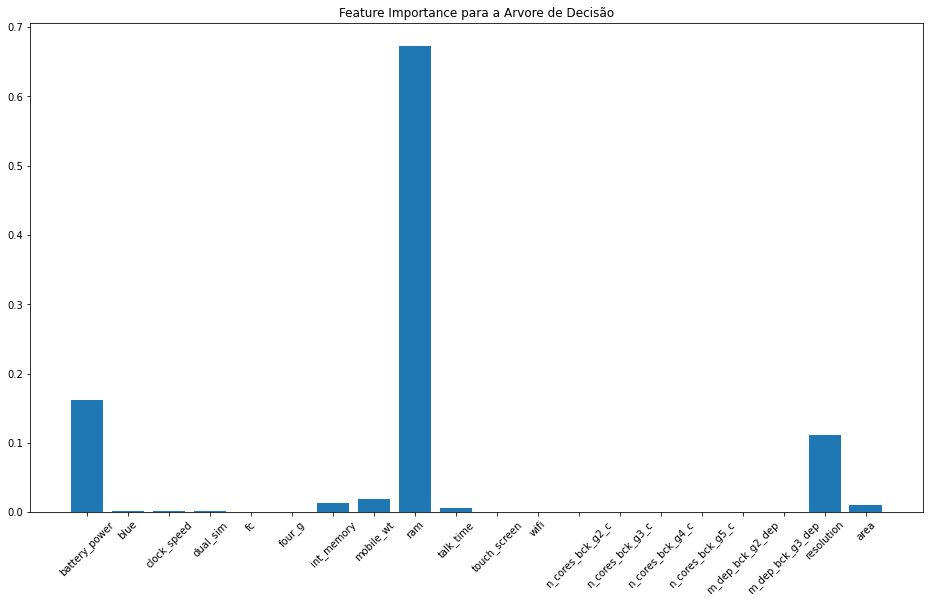

In [12]:
y_pred_val_dtree = tree.predict(X_val)
print(f'Matrix de Confusão para a arvore de decisão no dataset de validação:\n {confusion_matrix(y_val,y_pred_val_dtree)}')

fig,ax = plt.subplots(figsize=(16,9))
xticklabels = df.drop(columns=['price_range'],axis=1).columns.values
ax.bar(x=xticklabels,height=tree.feature_importances_)
ax.set_title("Feature Importance para a Arvore de Decisão")
ax.set_xticklabels(xticklabels,rotation=45)
fig.show()

In [13]:
# XGBoost
xgb_model = xgb.XGBClassifier(random_state=seed)

params2 = {'max_depth' : [2,3,5,7,10,12,15], 'learning_rate':[0.05,0.1,0.15,0.2,0.4,0.6]}

clf2 = GridSearchCV(xgb_model,params2)
clf2.fit(X_train, y_train)

xgb_model.set_params(learning_rate = clf2.best_params_['learning_rate'],max_depth = clf2.best_params_['max_depth'])
xgb_model.fit(X_train, y_train)

print(f'Acuracia para o treino: {xgb_model.score(X_train,y_train):.3f}')
print(f'Acuracia para a validacao: {xgb_model.score(X_val,y_val):.3f}')

Acuracia para o treino: 1.000
Acuracia para a validacao: 0.897


Melhores Hiperparametros para o XGBoost: {'learning_rate': 0.2, 'max_depth': 5}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


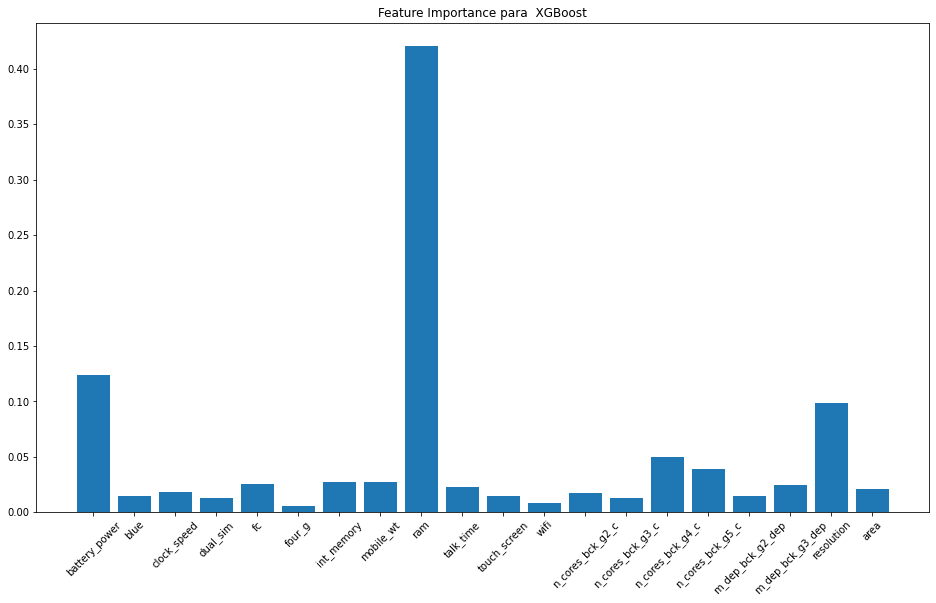

In [14]:
print(f'Melhores Hiperparametros para o XGBoost: {clf2.best_params_}')

fig,ax = plt.subplots(figsize=(16,9))
xticklabels = df.drop(columns=['price_range'],axis=1).columns.values
ax.bar(x=xticklabels,height=xgb_model.feature_importances_)
ax.set_title("Feature Importance para  XGBoost")
ax.set_xticklabels(xticklabels,rotation=45)
fig.show()

In [15]:
# Random Forest

rf = RandomForestClassifier(random_state=seed)

params_rf = {'max_depth' : [2,3,4,5,6,7,10,12,15]}

clf3 = GridSearchCV(rf,params_rf,cv = 10)
clf3.fit(X_train[:,[0,8,18]], y_train)

rf.set_params(max_depth = clf3.best_params_['max_depth'])
rf.fit(X_train[:,[0,8,18]], y_train)

print(f'Acuracia para o treino: {rf.score(X_train[:,[0,8,18]],y_train):.3f}')
print(f'Acuracia para a validacao: {rf.score(X_val[:,[0,8,18]],y_val):.3f}')

Acuracia para o treino: 1.000
Acuracia para a validacao: 0.890


In [16]:
print(f'Melhores Hiperparametros para o Random Forest: {clf3.best_params_}')


Melhores Hiperparametros para o Random Forest: {'max_depth': 12}
